In [2]:
# load required environment
import numpy as np
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt

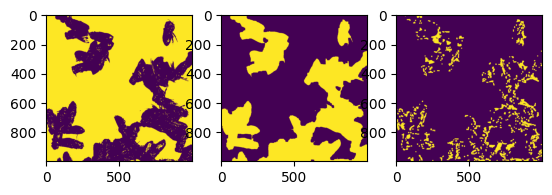

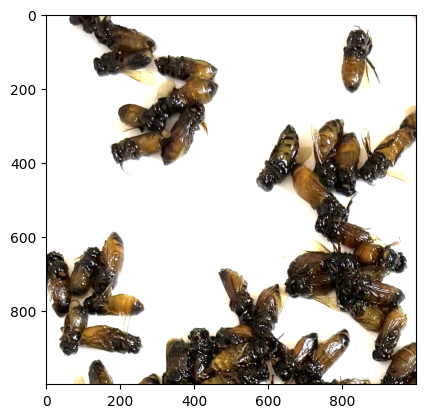

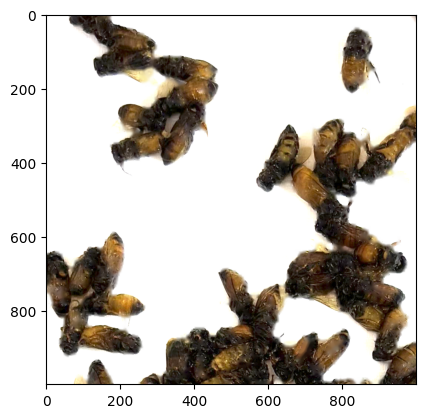

In [43]:
# load and crop image
img = cv.imread("in/bee-image-3-exposed.png")
img = img[1000:2000, 1000:2000]  # Crop the image to a smaller size for faster processing


# get image in different colorspaces for later use:
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# glare / noise removal
def deglare(img, hsv):
    mask = cv.inRange(hsv, (0, 0, 180), (180, 50, 255))
    
    mask1 = mask
    mask2 = ~cv.morphologyEx(mask, cv.MORPH_OPEN, np.ones((5, 5), np.uint8), iterations=3)
    mask = mask1 & (mask2)
    mask = cv.dilate(mask, np.ones((3, 3), np.uint8), iterations=3)

    plt.figure()
    plt.subplot(131)
    plt.imshow(mask1)
    plt.subplot(132)
    plt.imshow(mask2)
    plt.subplot(133)
    plt.imshow(mask)
    plt.show()

    # inpainted = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return cv.inpaint(img, mask, 10, cv.INPAINT_TELEA)

img_old = img.copy()
img_deglare = deglare(img, img_hsv)

plt.figure()
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

plt.figure()
plt.imshow(cv.cvtColor(img_deglare, cv.COLOR_BGR2RGB))
plt.show()

(1000, 1000)
(1000, 1000)
(1000, 1000)
1.0


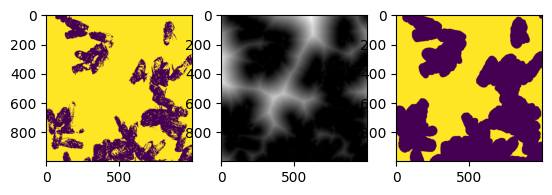

In [4]:
# get background region that is sufficiently far from bee clumps for background marking in watershed algorithm

_, bg_mask = cv.threshold(img_gray, 100, 1, cv.THRESH_BINARY)
bg_dist = cv.distanceTransform(bg_mask, cv.DIST_L2, 5)
bg_dist = cv.normalize(bg_dist, None, 0, 1, cv.NORM_MINMAX)
_, bg_markers = cv.threshold(bg_dist, 0.1, 1, cv.THRESH_BINARY)

print(bg_mask.shape)
print(bg_dist.shape)
print(bg_markers.shape)
print(bg_markers.max())

plt.figure()
plt.subplot(131)
plt.imshow(bg_mask)
plt.subplot(132)
plt.imshow(bg_dist, cmap='gray')
plt.subplot(133)
plt.imshow(bg_markers)
plt.show()

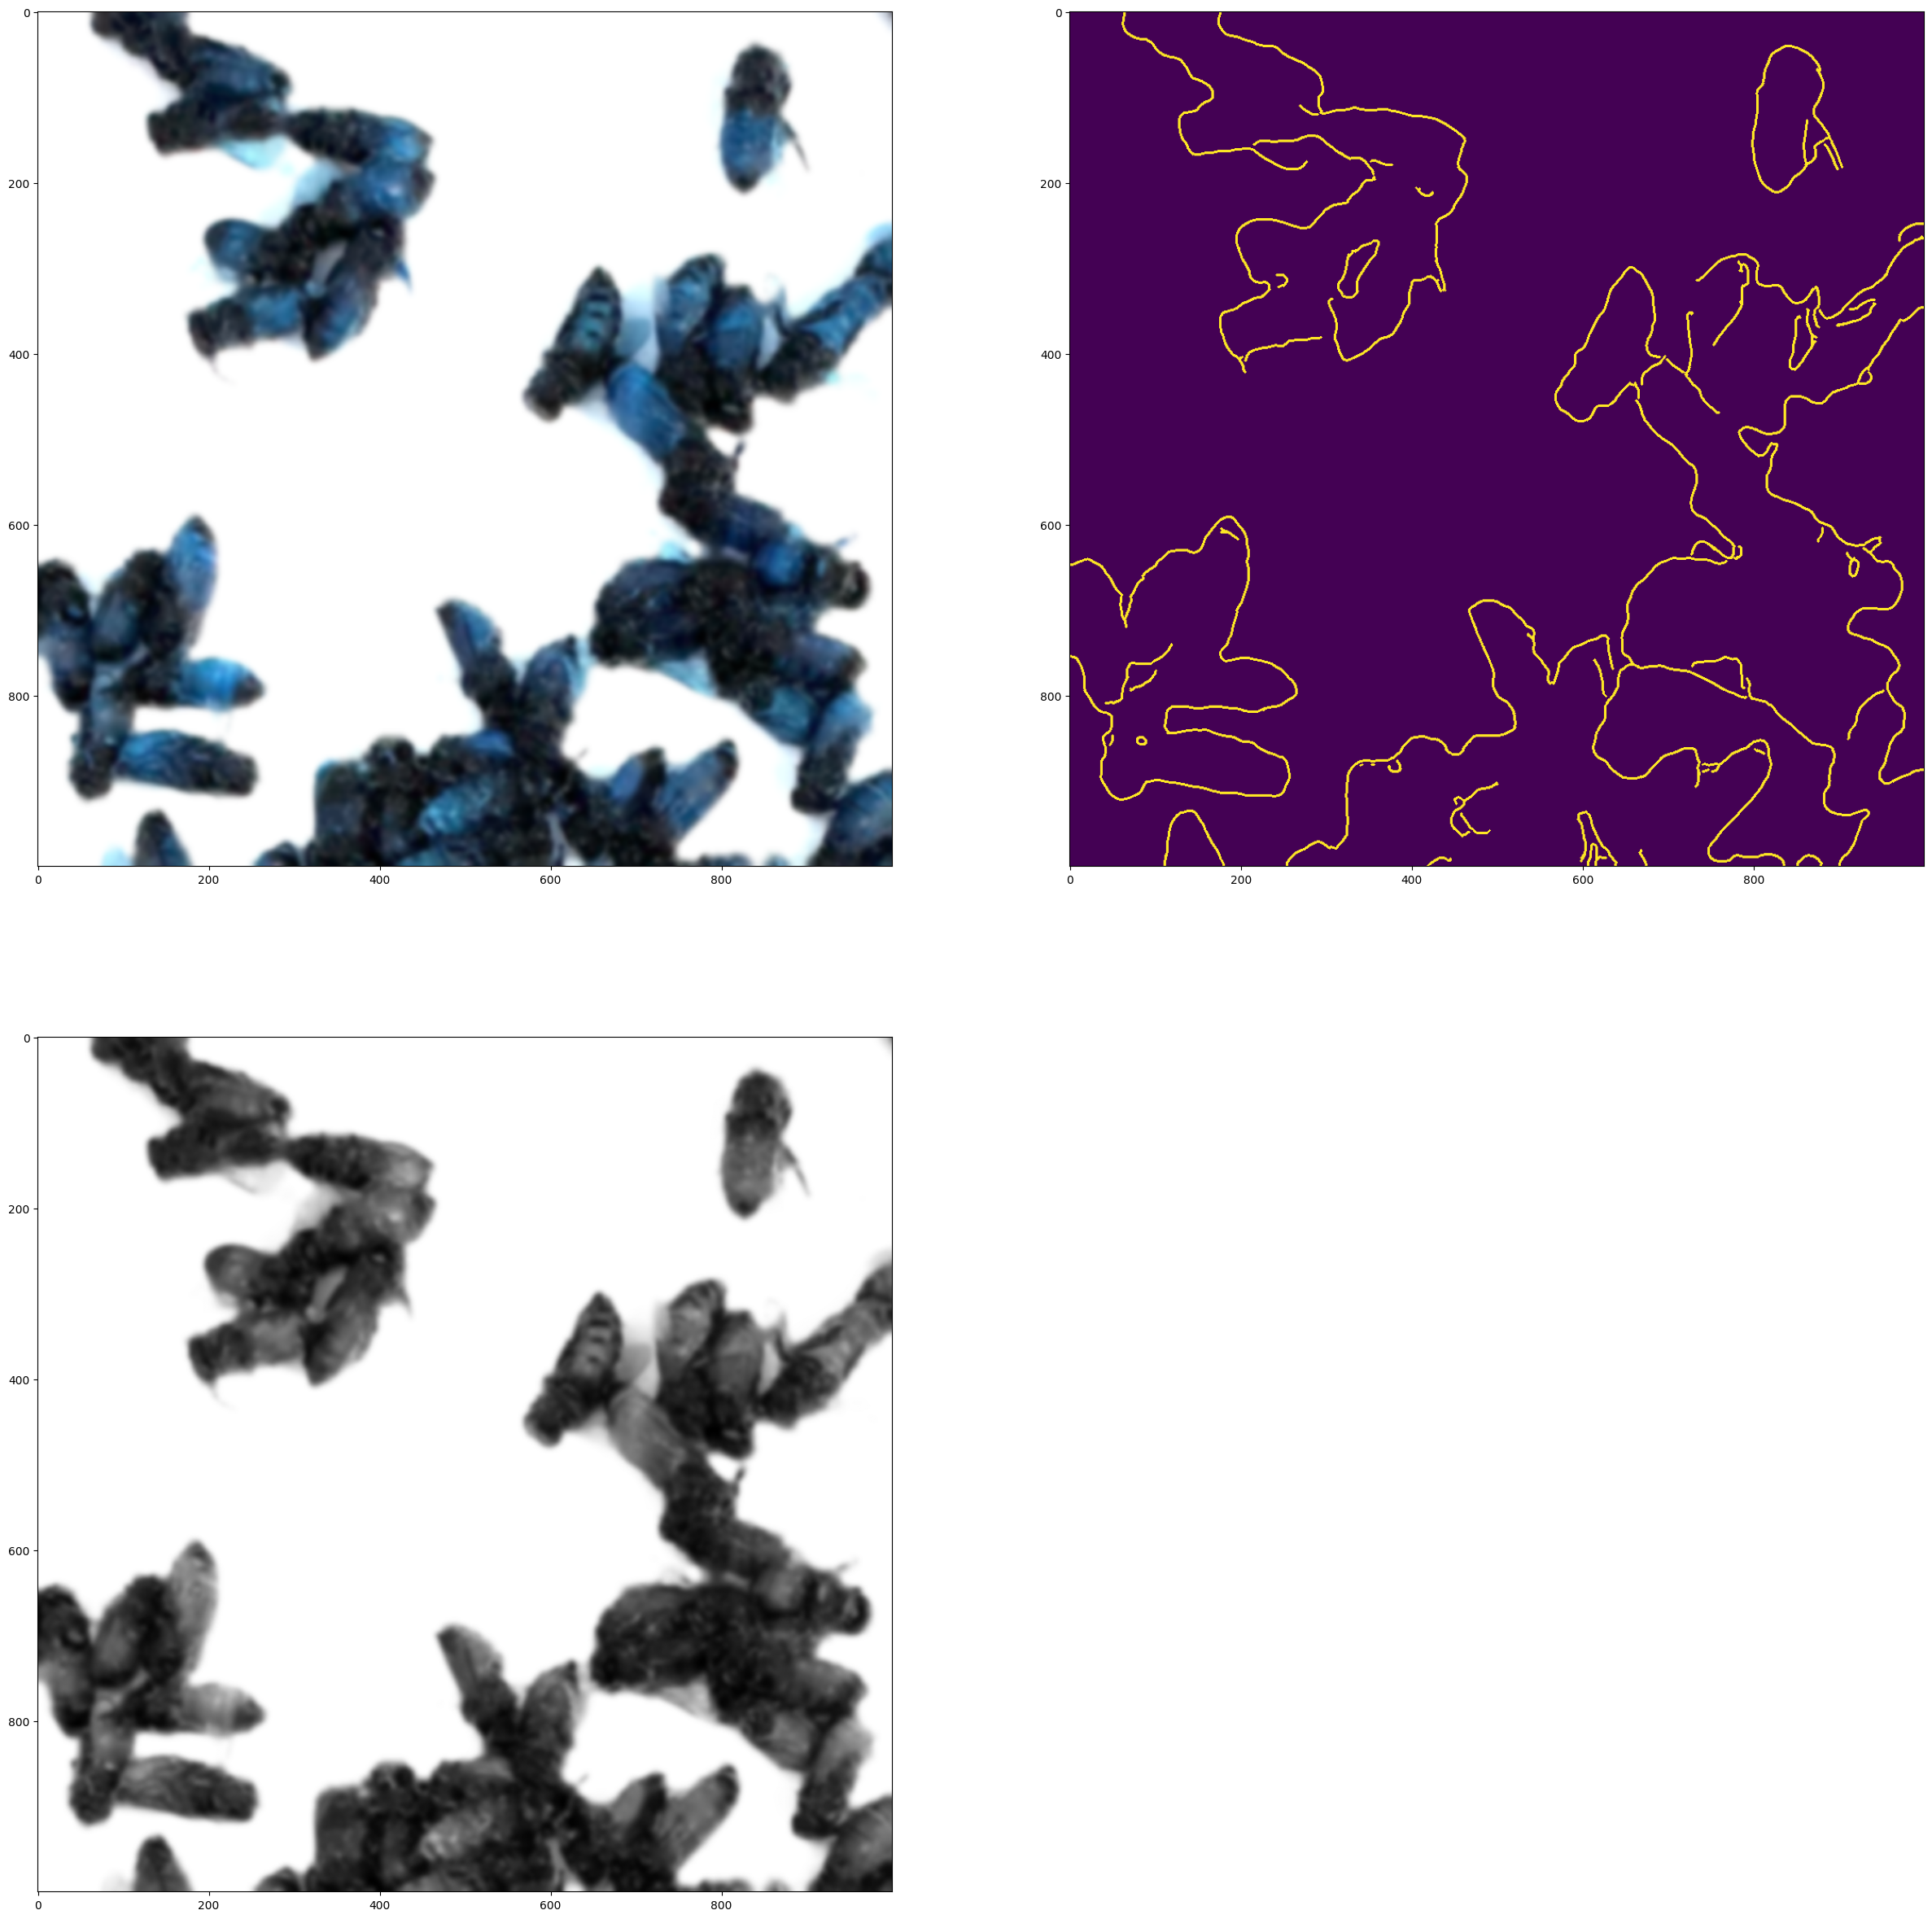

In [ ]:
# get the gradient for edge definition for watershed algorithm
# img_gray = cv.GaussianBlur(img_gray, (3, 3), 3)
# edges_inp = img_gray.copy().astype(np.float32)
# edges_inp = edges_inp * 0.5 + (img_hsv[:, :, 0]).astype(np.float32) * 0.5

# edges_inp = cv.cvtColor(img_deglare, cv.COLOR_BGR2GRAY)
# edges_inp = cv.bilateralFilter(edges_inp, 7, 200, 200)

edges_inp = img_deglare.copy()
edges_inp = cv.GaussianBlur(edges_inp, (17, 17), 3)

sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# edges_inp = cv.filter2D(edges_inp, -1, sharpen_kernel)

thresh_scale = 250
edges = cv.Canny(edges_inp, 40*thresh_scale, 100*thresh_scale, apertureSize=7, L2gradient=True)

edge_morph_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
edges = cv.dilate(edges, edge_morph_kernel, iterations=1)

# edges = cv.morphologyEx(edges, cv.MORPH_OPEN, edge_morph_kernel, iterations=1)

edges_2 = cv.cvtColor(edges_inp, cv.COLOR_BGR2GRAY)
# edges_2_mask = cv.inRange(edges_2, 0, 32)
# edges_2[edges_2_mask == 0] = 255

'''
edges = cv.Laplacian(edges_inp, cv.CV_64F, ksize=21)
edges = np.sqrt(edges**2)
# scharrx = cv.Scharr(edges_inp, cv.CV_64F, 1, 0)
# scharry = cv.Scharr(edges_inp, cv.CV_64F, 0, 1)
# scharr = np.sqrt(scharrx ** 2 + scharry ** 2)
# edges = np.uint8(cv.normalize(scharr, None, 0, 255, cv.NORM_MINMAX))

edges = np.uint8(cv.normalize(edges, None, 0, 255, cv.NORM_MINMAX))
edges[edges < 30] = 0
'''


plt.figure(figsize=(30, 30))
plt.subplot(221)
plt.imshow(edges_inp)
plt.subplot(222)
plt.imshow(edges)
plt.subplot(223)
plt.imshow(edges_2, cmap='gray')
plt.show()

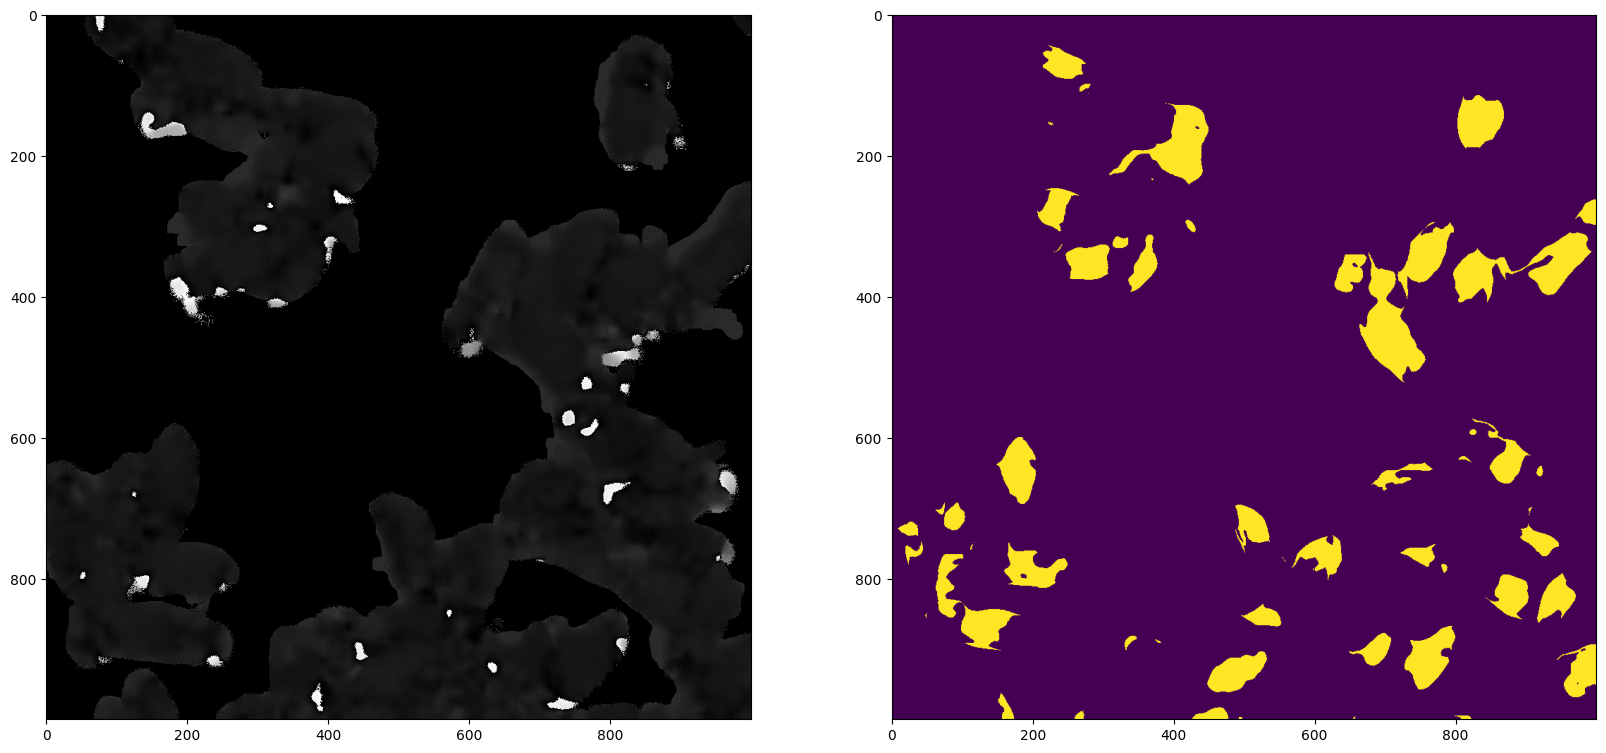

# contours: 65


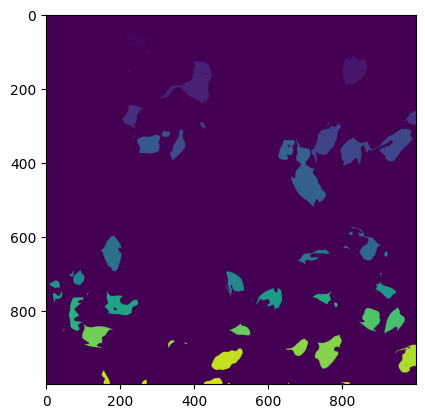

In [119]:
# get foreground region markers for watershed algorithm.
# These will be yellow features of the bees.


inp = img_deglare.copy()
inp = cv.GaussianBlur(inp, (15, 15), 10)
inp = cv.cvtColor(inp, cv.COLOR_BGR2HSV)
# inp = cv.GaussianBlur(img_hsv, 20)



# fg_mask1 = cv.inRange(inp, (hue_range[0], sat_range[0], val_range[0]), (hue_range[1], sat_range[1], val_range[1]))
fg_mask = cv.inRange(inp, (0, 100, 100), (30, 220, 200))
# fg_mask = cv.morphologyEx(fg_mask, cv.MORPH_CLOSE, np.ones((7, 7), np.uint8), iterations=2)
# fg_mask = cv.morphologyEx(fg_mask, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=2)
# fg_mask_dst = cv.distanceTransform(fg_mask, cv.DIST_L2, 5)
# fg_mask = cv.normalize(fg_mask_dst, None, 0, 1, cv.NORM_MINMAX)
# fg_mask = cv.threshold(fg_mask, 20, 1, cv.THRESH_BINARY)[1]

plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(inp[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(fg_mask)
plt.show()

contours, _ = cv.findContours(fg_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print("# contours:", len(contours))

_, fg_markers = cv.connectedComponents(fg_mask)
fg_mask_rm = cv.dilate(edges, edge_morph_kernel, iterations=1)
fg_markers[fg_mask_rm == 1] = 0

# fg_markers = np.zeros_like(inp)
# c = 0
# dc = 180 / len(contours)
# for i, cnt in enumerate(contours):
#     # if cv.contourArea(cnt) < 1000:
#     #     continue
#     c += dc
#     cv.drawContours(fg_markers, contours, i, (c, 128, 100 + c), -1)
#     # cv.drawContours(img, [cnt], -1, (0, 0, 255), 2)
# fg_markers = cv.cvtColor(fg_markers, cv.COLOR_HSV2RGB)

plt.figure()
plt.imshow(fg_markers)
plt.show()

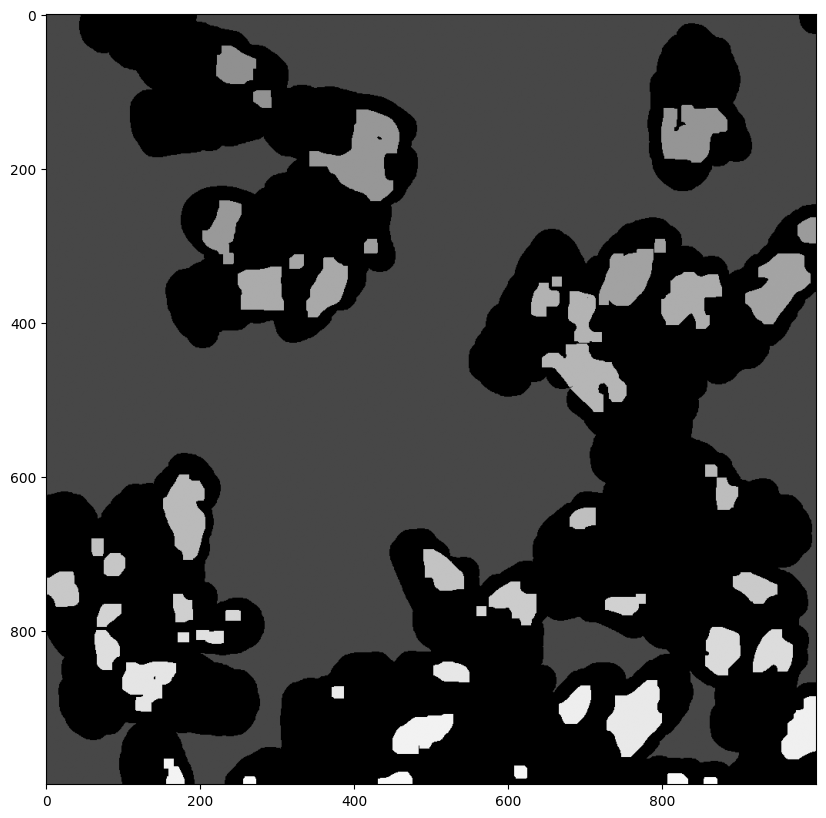

(1000, 1000) 115


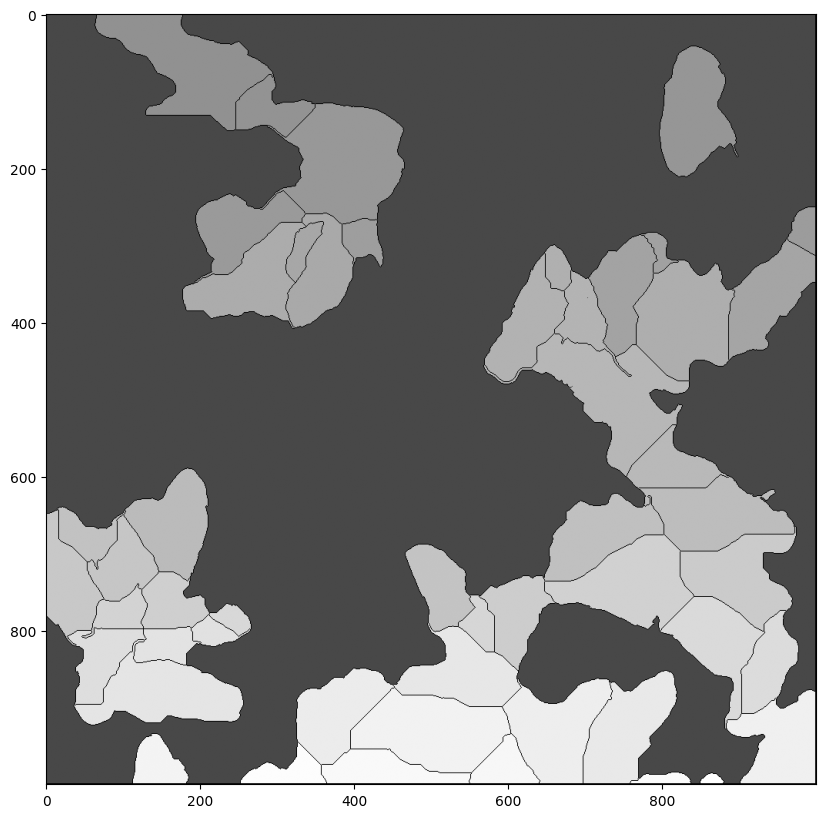

In [105]:
# actually do the watershed
plt.figure(figsize=(30, 10))

markers = fg_markers.copy()
markers[markers > 0] += 64
markers[bg_markers == 1] = 32
# markers[bg_markers == 1] = 
plt.imshow(markers, cmap='gray')
plt.show()

# markers = markers.astype(np.uint8)
# markers = cv.cvtColor(markers, cv.COLOR_GRAY2BGR)
markers_cpy = markers.copy()
edges_3ch = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

# inp = cv.cvtColor(img_deglare,)
inp_ws = img_hsv.copy()
inp_ws[:, :, 0] = 0
# inp_ws[:, :, 2] = 0
ws_markers = cv.watershed(edges_3ch, markers_cpy)

print(ws_markers.shape, ws_markers.max())

# the moment of truth:

plt.figure(figsize=(30, 10))
plt.imshow(ws_markers, cmap='gray')
plt.show()